# e3ferminet

An E(3)-equivariant neural network ansatz for atomic and molecular VMC calculations.

e3ferminet_new.svg

# Introduction

With the growing popularity of deep learning in recent years, many neural network models have been developed to model chemical systems (see e.g., refs. 17-26 of [Hermann et al. 2020](https://www.nature.com/articles/s41557-020-0544-y)). However, most of these models are trained with supervised learning, thus requiring solutions by existing computational chemistry methods such as DFT and the coupled-cluster method as training data. More recently, models were proposed where no training data is required to learn the ground states of quantum mechanical systems, including [Carleo and Troyer 2017](https://www.science.org/doi/10.1126/science.aag2302), [Han et al. 2019](https://www.sciencedirect.com/science/article/pii/S0021999119306345), [Hermann et al. 2020](https://www.nature.com/articles/s41557-020-0544-y), and [Pfau et al. 2020](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.033429). These works implement the traditional variational Monte Carlo (VMC) method to solve for the ground state wavefunction *ab initio*, but with a neural network inserted as the ansatz for the wavefunction. As such, they were able to leverage the high expressivity of the neural network to achieve high accuracy without any training data.

Neural network ansatze proposed to this date do not incorporate E(3) equivariance, namely, the fact that the ground state of a molecule does not depend on the coordinate system in which the molecule is represented. Thus, in our project, we aim to study the feasibility of using *E(3)-equivariant* neural networks as VMC ansatze for molecules.

This Jupyter notebook is organized as follows. First, we provide some background on VMC and describe past efforts in using neural networks as VMC ansatze. We then propose E3FermiNet, a modification of FermiNet ([Pfau et al. 2020](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.033429)) that incorporates E(3) equivariance. A light-weight implementation is given, so that readers can train E3FermiNet on a small molecule (borane BH<sub>3</sub>) within the notebook. We then describe results from our main experiments conducted with 6 atoms/molecules, and conclude with a discussion of the results and proposals for future work.

Our complete codebase is located at [this GitHub repository](https://github.com/uranium11010/e3ferminet). It includes instructions for replicating our experimental results, as well as other model architectures that we have tried. 

# Background and related work

## Variational Monte Carlo (VMC)

In computational chemistry, solving the ground state wavefunction of a molecule allows us to predict its properties accurately.
However, an exact solution to the wavefunction is computationally infeasible for these quantum many-body systems,
and various approximation methods have been proposed and studied over the last few decades.

A classical method is the variational Monte Carlo method (VMC).
VMC is a variant of the variational method, which finds the ground state wavefunction $\psi(x)$ by minimizing its expected energy
$$
    E[\psi] = \frac{\langle \psi| \hat H |\psi\rangle}{\langle \psi | \psi \rangle} = \frac{\int dx\, |\psi(x)|^2 \frac{\hat H\psi(x)}{\psi(x)}}{\int dx\, |\psi(x)|^2}.
$$
The symbol $\hat H$ is a Hermitian operator that encodes the total energy of the system, so that its eigenfunctions are the states with definite energy and their corresponding eigenvalues are their energies.
For a molecule with $M$ nuclei of atomic numbers $Z_1, \ldots, Z_M$ located at $\mathbf R_1, \ldots, \mathbf R_M$, the Hamiltonian of $N$ electrons interacting under the influence of these nuclei is given by
$$
\hat H = -\frac{1}{2} \sum_{i=1}^N \nabla_i^2 - \sum_{i=1}^N \sum_{m=1}^M \frac{Z_m}{|\mathbf r_i - \mathbf R_m|} + \sum_{1 \leq i < j \leq N} \frac{1}{|\mathbf r_i - \mathbf r_j|} + \sum_{1 \leq m \leq n \leq M} \frac{Z_mZ_n}{|\mathbf R_m - \mathbf R_n|},
$$
where $\mathbf r_i$ is the position of electron $i$ and $\nabla_i^2$ is the Laplacian with respect to the position of electron $i$.
The different terms in the Hamiltonian correspond to different parts of the total energy of the system:
- $-\frac{1}{2} \sum_{i=1}^N \nabla_i^2$ is the total kinetic energy of all electrons.
- $- \sum_{i=1}^N \sum_{m=1}^M \frac{Z_m}{|\mathbf r_i - \mathbf R_m|}$ is the total potential energy of all electron-nucleus pairs.
- $\sum_{1 \leq i < j \leq N} \frac{1}{|\mathbf r_i - \mathbf r_j|}$ is the total potential energy of all electron-electron pairs.
- $\sum_{1 \leq m \leq n \leq M} \frac{Z_mZ_n}{|\mathbf R_m - \mathbf R_n|}$ is the total potential energy of all nucleus-nucleus pairs.

Since $\psi(x)$ is a vector with infinitely many degrees of freedom, in practice chemists use an ansatz parameterized by a finite number of parameters $\theta$. The energy functional is then minimized with respect to these parameters.

Varational *Monte Carlo*, a variant of the variational method, makes the observation that the energy functional can be written as
$$
E[\psi] = \mathbb E_{x\sim p}[E_{\mathrm{loc}}(x)],
$$
where $p(x) \propto |\psi(x)|^2$ is the probability density and $E_{\mathrm{loc}} = \frac{\hat H\psi(x)}{\psi(x)}$ is the *local energy*.
The energy functional can thus be estimated by sampling points from $p$ to estimate the expectation value of $E_{\mathrm{loc}}$. Gradient descent is then performed with respect to the wavefunction ansatz parameters $\theta$ to obtain the ground state wavefunction and its corresponding energy.

## Metropolis-Hastings (M-H) sampling

How do we sample from an unknown distribution $|\psi(x)|^2$ that's not even normalized? A whole class of algorithms, Monte Carlo Markov Chain (MCMC), have been developed for this very purpose over the last few decades. The most popular MCMC algorithm for VMC is Metropolis-Hastings (M-H) (Figure 1).


m-h.svg

_Figure 1: Schematic for the Metropolis-Hastings (M-H) sampling algorithm_


At a high level, we conduct a random walk according to a predetermined transition function $q(y \mid x)$ called the _proposal distribution_. However, the random walk is modified such that each random step is rejected with a certain probabibility, so that the random walk converges to the target distribution $p$.

The details of the algorithm are as follows.
1. Pick an initial point $x \gets x_0$.
2. Repeat:
  1. Sample $y$ from $q(\cdot\mid x)$.
  2. Compute the *acceptance ratio*
$$
A(y, x) = \frac{q(x \mid y) p(y)}{q(y \mid x) p(x)}.
$$
  3. Accept, i.e., set $x \gets y$, with probability $\min(1, A(y, x))$.

It can be shown that the target distribution $p(x)$ is a stationary distribution of the Markov chain described above, so that in most cases $x$ converges to the distribution, as desired.

In VMC, a common choice is to use a Gaussian proposal distribution
$$
q(y \mid x) = \frac{1}{(2\pi\sigma^2)^{\frac{d}{2}}} \exp\left(-\frac{(y - x)^2}{2\sigma^2}\right)
$$
where $d$ is the dimension of $x$ ($d = 3N$ for $N$ particles in 3-dimensional space) and $\sigma$ is a hyperparameter. In practice, importance sampling is used to speed up convergence by introducing a bias in the mean of the proposal distribution (see [this](http://compphysics.github.io/ComputationalPhysics2/doc/pub/vmc/html/vmc-bs.html) reference for a detailed explanation). For simplicity, however, we will be using the simpler version where the Gaussian is centered at $x$.

## VMC ansatz

The main difficulty that now remains is to find a suitable ansatz for $\psi(x)$. Here, we focus on electron systems as found in atoms and molecules. For a system of $N$ electrons, a standard choice of ansatz is one of the Slater-Jastrow type:
\begin{equation}
\psi(\mathbf x_1, \ldots, \mathbf x_N) = e^J \det[\phi_i(\mathbf x_j)]. \tag{1}
\end{equation}
Here, $\mathbf x_i$ are the coordinates $(\mathbf r_i, s_i)$ of electron $i$, with $\mathbf r_i \in \mathbb R^3$ termed the *position coordinates* and $s_i \in \left\{-\frac12, +\frac12\right\}$ the *spin coordinate*.

The factor
$$
\det[\phi_i(\mathbf x_j)] = 
\begin{vmatrix}
    \phi_1(\mathbf x_1) & \phi_1(\mathbf x_2) & \cdots & \phi_1(\mathbf x_N) \\
    \phi_2(\mathbf x_1) & \phi_2(\mathbf x_2) & \cdots & \phi_2(\mathbf x_N) \\
    \vdots & \vdots & \ddots & \vdots \\
    \phi_N(\mathbf x_1) & \phi_N(\mathbf x_2) & \cdots & \phi_N(\mathbf x_N)
\end{vmatrix}
$$
in Eq. 1 is the *Slater determinant* of $N$ *molecular orbitals* $\phi_i(\mathbf x)$. They can be understood as single-electron wavefunctions of the $N$ electrons. Oftentimes, we know how many electrons are spin-up vs. spin-down, so that we can set $N_\uparrow$ electrons to be spin-up ($\phi_i(\mathbf r, s)$ is positive only if $s = +\frac12$) and the remaining $N_\downarrow = N - N_\uparrow$ to be spin-down ($\phi_i(\mathbf r, s)$ is positive only if $s = -\frac12$). Then the wavefunction of the system and the molecular orbitals can be written in terms of position coordinates only, and the Slater determinant is factorized into a product of a spin-up Slater determinant and a spin-down Slater determinant:
$$
\det[\phi_i(\mathbf x_j)] = \det[\phi_{\uparrow i}(\mathbf r_{\uparrow j})]\det[\phi_{\downarrow i}(\mathbf r_{\downarrow j})].
$$

The other factor $e^J$ in Eq. 1 is the *Jastrow factor*. A popular choice is $J = \sum_{i\neq j} u_{ij}(|\mathbf r_i - \mathbf r_j|)$, i.e., a function of all pairwise distances to account for electron correlation.

Since electrons are fermions, the wavefunction must be antisymmetric under the exchange of any two electrons:
$$
\psi(\mathbf x_1, \ldots, \mathbf x_i, \ldots, \mathbf x_j, \ldots, \mathbf x_N) = -\psi(\mathbf x_1, \ldots, \mathbf x_j, \ldots, \mathbf x_i, \ldots, \mathbf x_N).
$$
It can be easily checked that the Slater-Jastrow ansatz obeys antisymmetry.

Neural network ansatze for electron systems generally still follow the Slater-Jastrow form, with neural networks parameterizing the individual molecular orbitals $\phi_i(\mathbf x)$. Here are some examples.
- PauliNet ([Hermann et al. 2020](https://www.nature.com/articles/s41557-020-0544-y)) uses a Slater-Jastrow ansatz where the Jastrow factor is parameterize by a DNN, and the molecular orbitals use the result of the Hartree-Fock method as an initial approximation and are subsequently multiplied by a learnt neural network function to improve accuracy.
- FermiNet ([Pfau et al. 2020](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.033429)) does not use a Jastrow factor, but has a sum of Slater determinants of generalized molecular orbitals parameterized by a neural network. Here, a _generalized molecular orbital_ is one which is allowed to also depend on the unordered set $\{\mathbf r_{\uparrow j}\}$ of spin-up electrons and the set $\{\mathbf r_{\downarrow j}\}$ of spin-down electrons. This naturally incorporates electron correlation as the molecular orbital of an electron can depend on where other electrons are. In fact, it was shown in the paper that a single Slater determinant of generalized molecular orbitals is expressive enough to describe any antisymmetric wavefunction.
- MADE ([Humeniuk et al. 2023](https://arxiv.org/abs/2210.05871)) proposes an autoregressive model for a Slater-Jastrow ansatz that allows for directly sampling, thus eliminating potentially slow convergence time of M-H sampling. However, the model requires a discrete finite position space.

# Methods

First, let's check the Python version (should be 3.10 or 3.9) and import the modules/packages that we will need.

In [ ]:
# Check that the Python version is 3.10 or 3.9
%%python --version

Python 3.10.11


In [ ]:
# Install e3nn-jax, which we use to build the E3FermiNet ansatz
%%capture
!pip install e3nn-jax

In [ ]:
# Import required modules
from tqdm import tqdm
import pickle as pkl
import numpy as np
import pandas as pd
import plotly
import plotly.express as px

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
import flax
import optax

import e3nn_jax as e3nn  # import e3nn-jax

jax.config.update("jax_enable_x64", True)  # otherwise numerical errors during gradient computations could result in nan values

print(jax.__version__)
print(flax.__version__)
print(optax.__version__)
print(e3nn.__version__)
print(jnp.ones(()).device())  # should output gpu:0 if a GPU is available

0.4.8
0.6.9
0.1.5
0.17.5
TFRT_CPU_0


We base our model off of the FermiNet architecture and call it "E3FermiNet" (Figure 2). At a high level, it treats the electrons as a complete graph on $N$ vertices and applies a graph neural network (GNN) on node features alone. (Note that the original FermiNet architecture also has edge features, but we have simplified the architecture.) The input node features are E(3)-invariant features (scalars) constructed from positions of the electrons relative to the nuclei. As such, all features in the network are scalars so that E(3)-equivariance imposes no restriction on the architecture.

It is straightforward to show that all eigenfunctions of $\hat H$ can be chosen to be real, so we will assume a real ground state wavefunction and only work with real feature vectors and weight matrices.

For simplicity, we will assume the nuclei positions $\mathbf R_m$ are known. Also, suppose we know that $N_\uparrow$ electrons are spin-up and the remaining $N_\downarrow = N - N_\uparrow$ electrons are spin-down, so that we can label the spin-up electrons $1, \ldots, N_\uparrow$ and the spin-down electrons $N_\uparrow+1, \ldots, N$.

e3ferminet_new.svg

_Figure 2: E3FermiNet architecture_

1. From the electron positions $\mathbf r_j$ and nuclei positions $\mathbf R_m$, we compute the relative positions $\mathbf r_j - \mathbf R_m$, which are translation-invariant. Their unnormalized real spherical harmonics
$$
y_{ljm} := Y_l(\mathbf r_j - \mathbf R_m)
$$
transform as $l$-odd irreps of $\mathrm O(3)$. Thus, the magnitudes $|y_{ljm}|$ and pairwise dot products $y_{ljm} \cdot y_{lkm}$
are scalars, i.e., transform as $0e$ irreps. Thus, we can define scalar node features
$$
h^{(0)}_j = \mathrm{concat}(|y_{ljm}|, y_{ljm} \cdot y_{l\uparrow m}, y_{ljm} \cdot y_{l\downarrow m}\ \forall 1 \leq m \leq M, 0 \leq l \leq l_{\mathrm{max}}),
$$
where $l_{\mathrm{max}}$ is a hyperparameter,
$$
y_{l\uparrow m} := \frac{1}{N_\uparrow} \sum_{j=1}^{N_{\uparrow}} y_{ljm}
$$
is the average of the spherical harmonics over all spin-up electrons, and
$$
y_{l\uparrow m} := \frac{1}{N_\downarrow} \sum_{j=N_{\uparrow}+1}^N y_{ljm}
$$
is the average of the spherical harmonics over all spin-down electrons. Averages are taken to ensure that the features are equivariant to permutations among spin-up electrons and among spin-down electrons, which is necessary for the final Slater determinant to be an antisymmetric function.
2. These scalar node features are passed through $L$ GNN layers. Each layer is defined as follows:
$$
h^{(l+1)}_j = \mathrm{GeLU}\left(W^{(l)}\mathrm{concat}\left(h^{(l)}_j, h^{(l)}_\uparrow, h^{(l)}_\downarrow\right) + b^{(l)}\right) + h^{(l)}_j
$$
where the $h^{(l)}_j$ term at the end is omitted for $l = 0$ as the dimensions are incompatabile. Note that the equation can be decomposed into 4 sublayers:
  1. Each feature $h_j^{(l)}$ is concatenated with the average of features of spin-up electrons, $h^{(l)}_\uparrow = \frac{1}{N_\uparrow} \sum_{j=1}^{N_\uparrow} h^{(l)}_j$, and the average of features of spin-down electrons, $h^{(l)}_\downarrow = \frac{1}{N_\downarrow} \sum_{j=1}^{N_\downarrow} h^{(l)}_j$. As before, these averages are taken to ensure that the features are equivariant to permutations of spin-up electrons and of spin-down electrons, so that the final Slater determinant is an antisymmetric function.
  2. The result is then fed into a linear layer with bias to yield $z^{(l)} = W^{(l)}\mathrm{concat}\left(h^{(l)}_j, h^{(l)}_\uparrow, h^{(l)}_\downarrow\right) + b^{(l)}$.
  3. The output from the linear layer is fed through a GeLU nonlinear activation layer to obtain $a^{(l)} = \mathrm{GeLU}(z^{(l)})$.
  4. Finally, for layers $l > 0$, we add a residual connection: $h^{(l+1)} = a^{(l)} + h^{(l)}$.
3. The features $h^{(L)}_j$ from the last layer of the GNN is passed through another linear layer:
$$
f_j = \tilde Wh^{(L)}_j + \tilde b.
$$
The dimension of $f_j$ is constrained to be $N$, as the indices will correspond to the $N$ molecular orbitals. 
4. The $f_j$ are multiplied by an exponentially decreasing envelope to yield the molecular orbitals:
$$
\phi_i(\mathbf r_j; \{\mathbf r_{\uparrow k}\}, \{\mathbf r_{\downarrow k}\}) = f_{ji} \sum_{m=1}^M \beta_{im} \exp(-\zeta_{im}|\mathbf r_j - \mathbf R_m|),
$$
where $\beta_{im} \geq 0$ and $\zeta_{im} > 0$ are parameters to be optimized. The inequalities are enforced by taking the absolute value for $\beta_{im}$ and taking the absolute value and adding a margin $\zeta_{\mathrm{min}} > 0$ for $\zeta_{im}$. Note that $\phi_i(\mathbf r_j; \{\mathbf r_{\uparrow k}\}, \{\mathbf r_{\downarrow k}\})$ depends on the locations of the spin-up (spin-down) electrons but is invariant to their order, as all layers of the network have been constructed to be equivariant to permuations of spin-up (spin-down) electrons.
5. The final wavefunction is computed as a slater determinant of the molecular orbitals:
$$
\psi(\mathbf r_1, \ldots, \mathbf r_N) = \det[\phi_{\uparrow i}(\mathbf r_{\uparrow j}; \{\mathbf r_{\uparrow k}\}, \{\mathbf r_{\downarrow k}\})]\det[\phi_{\downarrow i}(\mathbf r_{\downarrow j}; \{\mathbf r_{\uparrow k}\}, \{\mathbf r_{\downarrow k}\})].
$$
Here, $\uparrow i$ and $\uparrow j$ refer to indices $i$ and $j$ that range only over the spin-up electrons; $\downarrow i$ and $\downarrow j$ are defined similarly for spin-down electrons.

The E3FermiNet architecture is implemented in the class `E3FermiNetAnsatz` below.

In [ ]:
class E3FermiNetAnsatz:
    """
    Implements the E3FermiNet ansatz
    """

    def __init__(self, nuclei_coords: jnp.ndarray, N_up: int, N_down: int, config: dict):
        # Basic information about the molecule
        self.nuclei_coords = nuclei_coords   # coordinates of nuclei; (M, 3) jnp.ndarray
        self.M = len(nuclei_coords)          # number of nuclei
        self.N_up = N_up                     # number of spin-up electrons
        self.N_down = N_down                 # number of spin-up electrons
        self.N = N_up + N_down               # total number of electrons

        # hyperparameters
        self.lmax = config["lmax"]              # largest l in the spherical harmonics used to construct scalar features
        self.hidden_dim = config["hidden_dim"]  # dimmension of hidden features in GNN
        self.num_layers = config["num_layers"]  # number of layers in GNN
        self.beta_min = config["beta_min"]      # minimum beta (coefficient before the exponential) in the envelope 
        self.zeta_min = config["zeta_min"]      # minimum zeta (coefficient in the exponent) in the envelope

        # layer for converting electron positions into scalar features built from magnitudes and overlaps of spherical harmonics
        def get_scalars(x: jnp.ndarray):
            """
            x: (..., N, 3) jnp.ndarray, coordinates of the N electrons; may be batched or unbatched
            returns scalar features to be fed into the GNN
            """
            # positions of electrons relative to each nucleus
            x_rel_array = jnp.expand_dims(x, axis=-2) - self.nuclei_coords  # (..., N, M, 3)
            x_rel = e3nn.IrrepsArray("1o", x_rel_array)
            # spherical harmonics y_jml = Y_l(r_j - R_m) for l = 0, ..., lmax
            sh_x_rel = e3nn.spherical_harmonics(range(1, self.lmax+1), x_rel, normalize=False, normalization="norm")  # (..., N, M, (l+1)**2)
            # norms |y_jml| of spherical harmonics
            sh_x_rel_norms = e3nn.norm(sh_x_rel)  # (..., N, M, l+1)
            if self.N_up == 0 or self.N_down == 0:
                sh_avg = e3nn.mean(sh_x_rel, axis=-3, keepdims=True)         # average of y_jml over electrons j
                overlap_sh_avg = e3nn.dot(sh_x_rel, sh_avg, per_irrep=True)  # dot products between y_jml and average
                scalars = e3nn.concatenate([sh_x_rel_norms, overlap_sh_avg]).array  # (..., N, M, F)
            else:
                sh_avg_up = e3nn.mean(sh_x_rel[...,:self.N_up,:,:], axis=-3, keepdims=True)    # average of y_jml over spin-up electrons j
                overlap_sh_avg_up = e3nn.dot(sh_x_rel, sh_avg_up, per_irrep=True)              # dot products between y_jml and spin-up average
                sh_avg_down = e3nn.mean(sh_x_rel[...,self.N_up:,:,:], axis=-3, keepdims=True)  # average of y_jml over spin-down electrons j
                overlap_sh_avg_down = e3nn.dot(sh_x_rel, sh_avg_down, per_irrep=True)          # dot products between y_jml and spin-down average
                scalars = e3nn.concatenate([sh_x_rel_norms, overlap_sh_avg_up, overlap_sh_avg_down]).array  # (..., N, M, F)
            return e3nn.IrrepsArray(self.M * scalars.shape[-1] * e3nn.Irrep(0, 1), scalars.reshape(scalars.shape[:-2] + (-1,)))  # (..., N, M*F)
        self.get_scalars = get_scalars

        # GNN layers
        self.layers = []
        for i in range(self.num_layers):
            if self.N_up == 0 or self.N_down == 0:
                averaging_sublayer = lambda h: e3nn.mean(h, axis=-2, keepdims=True)  # mean electron feature
            else:
                averaging_sublayer = lambda h: e3nn.concatenate([
                    e3nn.mean(h[...,:self.N_up,:], axis=-2, keepdims=True),  # mean spin-up electron feature
                    e3nn.mean(h[...,self.N_up:,:], axis=-2, keepdims=True)   # mean spin-down electron feature
                ])
            GNN_layer = {
                "averaging": averaging_sublayer,
                "concat": lambda h, avg: e3nn.concatenate([h, e3nn.concatenate([avg] * self.N, axis=-2)]),
                "linear": e3nn.flax.Linear(self.hidden_dim * e3nn.Irrep(0, 1), biases=True),
                "activation": e3nn.scalar_activation
            }
            if i > 0:
                GNN_layer["residual"] = lambda a, h: a + h
            self.layers.append(GNN_layer)

        # final linear layer (between GNN and envelope)
        self.linear_head = e3nn.flax.Linear(irreps_out=self.N * e3nn.Irrep(0, 1), biases=True)

        # envelope for enforcing wavefunction boundary conditions
        def envelope(zeta: jnp.ndarray, beta: jnp.ndarray, x: jnp.ndarray):
            """
            zeta: (N, M) jnp.ndarray, coefficients in the exponent of the exponential
            beta: (N, M) jnp.ndarray, coefficients multiplying the exponential
            x: (..., N, 3) jnp.ndarray, positions $\mathbf r_j$ of the electrons
            returns the envelope e, with $e_{ji} = \sum_{m=1}^M \beta_{im} \exp(-\zeta_{im}|\mathbf r_j - \mathbf R_m|)$
            """
            rel_dists = jnp.linalg.norm(jnp.expand_dims(x, axis=-2) - self.nuclei_coords, axis=-1)  # (..., N, M), $|\mathbf r_j - \mathbf R_m|$
            exponents = zeta * jnp.expand_dims(rel_dists, axis=-2)  # (..., N (j), N (i), M), $\zeta_{im}|\mathbf r_j - \mathbf R_m|$
            envelopes = beta * jnp.exp(-exponents)  # (..., N (j), N (i), M), $\beta_{im} \exp(-\zeta_{im}|\mathbf r_j - \mathbf R_m|)$
            return jnp.sum(envelopes, axis=-1)  # (..., N (j), N (i))
        self.envelope = envelope

        @jit
        def wavefunction(w, coords: jnp.ndarray):
            """
            E3FermiNet wavefunction ansatz

            w: weights (parameters) of the ansatz
            coords: (..., 3*N) jnp.ndarray, electron positions at which to evaluate the wavefunction;
                                            of the form (x1, y1, z1, x2, y2, z2, ..., xN, yN, zN);
                                            can be batched or unbatched
            returns value of the wavefunction given the electron positions; of shape (...)
            """
            x = coords.reshape(coords.shape[:-1] + (self.N, 3))
            # get scalar features
            h = self.get_scalars(x)
            # pass through GNN layers
            for i, layer in enumerate(self.layers):
                avg = layer["averaging"](h)
                h_avg = layer["concat"](h, avg)
                z = layer["linear"].apply(w["linear_hidden"][i], h_avg)
                a = layer["activation"](z)
                if i == 0:
                    h = a
                else:
                    h = layer["residual"](a, h)
            # final linear layer (between GNN and envelope)
            z = self.linear_head.apply(w["linear_head"], h).array  # (..., N (j), N (i))
            # envelope
            e = self.envelope(jnp.abs(w["envelope_exponent"]) + self.zeta_min,
                              jnp.abs(w["envelope_coeffs"]) + self.beta_min,
                              x)  # (..., N (j), N (i))
            phi = z * e  # (..., N (j), N (i))
            # Slater determinant
            D_up = jnp.linalg.det(phi[...,:self.N_up,:self.N_up])
            D_down = jnp.linalg.det(phi[...,self.N_up:,self.N_up:])
            return D_up * D_down
        self.wavefunction = wavefunction

    def init_weights(self, random_key):
        """
        Initialize the weights (parameters) of the ansatz

        random_key: random key used for random initialization
        returns randomly initialized weights for the ansatz
        """
        subkeys = jax.random.split(random_key, num=self.num_layers+2)
        w = {"linear_hidden": []}
        coords = jnp.empty(3 * self.N)
        x = coords.reshape(coords.shape[:-1] + (self.N, 3))
        h = self.get_scalars(x)
        print("SHAPES OF INTERMEDIATES IN THE NEURAL NET:")
        print("h:", h.shape, h.irreps)
        for i, layer in enumerate(self.layers):
            avg = layer["averaging"](h)
            print("avg:", avg.shape, avg.irreps)
            h_avg = layer["concat"](h, avg)
            print("h_avg:", h_avg.shape, h_avg.irreps)
            w["linear_hidden"].append(layer["linear"].init(subkeys[i], h_avg))
            z = layer["linear"].apply(w["linear_hidden"][i], h_avg)
            print("z:", z.shape, z.irreps)
            a = layer["activation"](z)
            print("a:", a.shape, a.irreps)
            if i == 0:
                h = a
            else:
                h = layer["residual"](a, h)
            print("h:", h.shape, h.irreps)
        w["linear_head"] = self.linear_head.init(subkeys[self.num_layers], h)
        z = self.linear_head.apply(w["linear_head"], h).array
        print("z:", z.shape)
        w["envelope_exponent"] = jnp.sqrt(jax.random.chisquare(subkeys[self.num_layers+1], shape=(self.N, self.M), df=2)) * 0.5
        w["envelope_coeffs"] = jnp.sqrt(jax.random.chisquare(subkeys[self.num_layers+2], shape=(self.N, self.M), df=2)) * 0.5
        e = self.envelope(jnp.abs(w["envelope_exponent"]) + 0.5, jnp.abs(w["envelope_coeffs"]) + 0.5, x)  # (..., N (j), N (i))
        print("e:", e.shape)
        phi = z * e
        print("phi:", phi.shape)
        D_up = jnp.linalg.det(phi[...,:self.N_up,:self.N_up])
        print("D_up:", D_up.shape)
        D_down = jnp.linalg.det(phi[...,self.N_up:,self.N_up:])
        print("D_down:", D_down.shape)
        psi = D_up * D_down
        print("psi:", psi.shape)
        return w

# Experiments

Having implemented the E3FermiNet ansatz, let's write a training module. Within the training module, we implement the loss function, namely the local energy $E_{\mathrm{loc}}(x) = \frac{\hat H\psi(x)}{\psi(x)}$ of the wavefunction, the Metropolis-Hastings sampling algorithm, and the training loop.

The training loop implements batch gradient descent. For every batch $\{x_1, \ldots, x_B\}$ of $B$ points sampled from $p(x) \propto |\psi_\theta(x)|^2$, we compute the loss
$$
\mathcal L(\theta) = \frac{1}{B} \sum_{b=1}^B E_{\mathrm{loc}}(x_b),
$$
which is the estimate of the expected energy $E[\psi_\theta] = \mathbb E_{x\sim p}[E_{\mathrm{loc}}(x)]$ of the wavefunction. Then the parameters $\theta$ of the wavefunction ansatz are updated using gradient descent. The update step for vanilla gradient descent is
$$
\theta_{t+1} \gets \theta_t - \alpha_t \nabla_\theta \mathcal L(\theta_t),
$$
where $\alpha$ is the learning rate. We will instead be using a more sophisticated gradient descent algorithm such as [AdamW](https://optax.readthedocs.io/en/latest/api.html#optax.adamw). Note that the gradient $\nabla_\theta \mathcal L$ treats the sample points $x_b$ as fixed for simplicity, so that the dependence on $\theta$ only enters through the kinetic energy term $-\frac{\nabla^2\psi}{2\psi}$ of the local energy. In reality, the energy functional depends on $\theta$ also through the distribution over which the expectation value of $E_{\mathrm{loc}}$ is taken. However, taking this into account during the computation of the gradient is quite involved ([Pfau et al. 2020](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.033429)) and is deferred to future work.

Sampling from Metropolis-Hastings is batched as well, although not necessarily with the same batch size. For a batch size of $\tilde B$, we initialize $\tilde B$ points $x_{10}, \ldots, x_{\tilde B0}$ at the same time, and evolve all of the simultaneously according to M-H. We wait for a certain number of warmup steps for the Markov chains to converge to the target distribution $p(x) \propto |\psi_\theta(x)|^2$. We then gather the points from the next $\left\lceil B/\tilde B\right\rceil$ steps and take the first $B$ of them (which could be all of them) as our batch of points used for gradient descent. Since these points should ideally already be following the target distribution, we cache them so that a smaller number of warmup steps is needed the next time we sample points. <!-- Note that we still use some number of warmup steps to reduce correlation from the previous batch of samples and to allow convergence to the new target distribution, which has changed slightly as the parameters of the wavefunction have been updated. -->

In [ ]:
class E3FermiNetTrainingModule:
    """
    Training class.
    Implements
    - the loss function, i.e., energy function $E[\psi]$ of the wavefunction $\psi$
    - M-H sampling from the wavefunction
    - training loop for optimizing the wavefunction
    The wavefunction ansatz itself is implemented in a separate class `E3FermiNetAnsatz`
    """

    def __init__(self, config: dict):
        # Parameters of the system
        self.Zs = config["Zs"]  # length-M array of atomic numbers of nuclei
        self.nuclei_coords = jnp.array(config["nuclei_coords"])  # (M, 3)-array of coordinates of nuclei
        self.N_up = config["N_up"]  # number of spin-up electrons
        self.N_down = config["N_down"]  # number of spin-down electrons
        self.N = self.N_up + self.N_down  # total number of electrons

        # Training parameters
        self.batch_size = config["batch_size"]  # batch size for training, i.e., number of samples used to estimate the average E_loc
        self.val_num_samples = config["val_num_samples"]  # number of samples used to estimate the energy during validation
        self.num_batches = config["num_batches"]  # total number of training batches in the training loop
        self.lr = config["lr"]  # learning rate
        if isinstance(self.lr, dict):
            self.lr = optax.warmup_cosine_decay_schedule(**self.lr)
        self.validate_every = config["validate_every"]  # interval (number of training batches) between two consecutive validations
        self.random_key = jax.random.PRNGKey(config["random_seed"])  # random key for random number generation

        # Wavefunction ansatz (to be implemented below)
        self.ansatz = E3FermiNetAnsatz(self.nuclei_coords, self.N_up, self.N_down, config["ansatz"])

        # Weights and validation losses will be stored here
        self.w = None  # stores the current weights during training
        self.w_list = None  # checkpoints
        self.energies = None  # validation losses

        ###########################################################################
        # Functions for building up the Hamiltonian of the system (loss function) #
        ###########################################################################

        @jit
        def local_kinetic_energy(w, coords: jnp.ndarray):
            """
            w: weights for the wavefunction ansatz
            coords: (3*N,) jnp.ndarray, coordinates of the electrons as N triplets (x, y, z) concatenated together
            returns local kinetic energy of the system at `coords`, $-\frac12 \sum_i \nabla_i^2$
            """
            def laplacian(coords):
                return jnp.einsum('ii->', jacobian(jacobian(self.ansatz.wavefunction, argnums=1), argnums=1)(w, coords))
            return -0.5 * laplacian(coords) / self.ansatz.wavefunction(w, coords)
        self._local_kinetic_energy = local_kinetic_energy

        @jit
        def local_potential_energy(w, coords: jnp.ndarray):
            """
            w: weights for the wavefunction ansatz
            coords: (3*N,) jnp.ndarray, coordinates of the electrons as N triplets (x, y, z) concatenated together
            returns local potential energy of the system at `coords`,
                $- \sum_{i=1}^N \sum_{m=1}^M \frac{Z_m}{|\mathbf r_i - \mathbf R_m|}
                + \sum_{1 \leq i < j \leq N} \frac{1}{|\mathbf r_i - \mathbf r_j|}$
            """
            expanded_coords = coords.reshape((-1, 1, 3))
            rel_positions = expanded_coords - self.nuclei_coords  # (N, M, 3)
            V_e_p = -jnp.sum(jnp.array(self.Zs) / jnp.linalg.norm(rel_positions, axis=2))  # electron-nucleus interactions
            coords = coords.reshape((-1, 3))
            relative_dists = jnp.linalg.norm(jnp.expand_dims(coords, axis=0) - jnp.expand_dims(coords, axis=1), axis=2)
            V_e_e = jnp.sum(1.0 / jnp.where(relative_dists == 0.0, np.inf, relative_dists)) / 2  # electon-electron interactions
            return V_e_p + V_e_e
        self._local_potential_energy = local_potential_energy

        @jit
        def local_energy(w, coords: jnp.ndarray):
            """
            w: weights for the wavefunction ansatz
            coords: (3*N,) jnp.ndarray, coordinates of the electrons as N triplets (x, y, z) concatenated together
            returns local energy of the system at `coords`, $E_{\mathrm{loc}}(\mathbf r_1, \ldots, \mathbf r_N)$
            """
            return local_kinetic_energy(w, coords) + local_potential_energy(w, coords)
        self._local_energy = local_energy

        @jit
        def energy(w, coords_batch: jnp.ndarray):
            """
            w: weights for the wavefunction ansatz
            coords_batch: (B, 3*N) jnp.ndarray, batch of points sampled from the wavefunction
            returns estimate of the expected energy of the wavefunction, i.e., mean of local energies at the points `coords_batch`
            """
            local_energies = vmap(local_energy, in_axes=(None, 0))(w, coords_batch)
            return jnp.mean(local_energies)
        self._energy = energy

        ################################
        # Metropolis-Hastings sampling #
        ################################

        self.MH_stdev = config["MH"]["stdev"]  # standard deviation of proposal distribution q(y|x)
        self.MH_warmup = config["MH"]["warmup"]  # number of warmup steps
        self.MH_interval = config["MH"]["interval"]  # interval between consecutive samples (to reduce correlation)
        self.MH_batch_size = config["MH"]["batch_size"]  # number of M-Hs going on in parallel
        self.sampled_coords = None  # stores last sampled coordinates so that reinitialization + warmup can be omitted
                                    # after the first batch of samples

        def sampler(random_key, num_samples: int):
            """
            Implements batched M-H sampling.

            random_key: random key for generating random samples
            num_samples: number of samples to generate (need not equal self.MH_batch_size)
            returns jnp.ndarray of shape (num_samples, 3*Z) sampled from the wavefunction using weights self.w
            """
            if self.sampled_coords is None:  # warmup
                warmup = self.MH_warmup
                random_key, subkey = jax.random.split(random_key)
                # initialize electrons as gaussians around nuclei
                # electrons are assigned to nuclei according to their atomic numbers
                # 1. assign electrons to atoms
                num_electrons = [0 for _ in range(len(self.Zs))]
                electrons_left = self.N
                while electrons_left > 0:
                    new_electrons_left = electrons_left
                    for i in range(len(self.Zs)):
                        if num_electrons[i] < self.Zs[i]:
                            num_electrons[i] += 1
                            new_electrons_left -= 1
                            if new_electrons_left == 0:
                                break
                    if electrons_left == new_electrons_left:
                        break
                    electrons_left = new_electrons_left
                if electrons_left > 0:
                    while electrons_left > 0:
                        for i in range(len(self.Zs)):
                            num_electrons[i] += 1
                            electrons_left -= 1
                            if electrons_left == 0:
                                break
                # 2. center of gaussians of initial electron distribtion (positions of nuclei the electrons are assigned to)
                coords_centers = jnp.concatenate([self.nuclei_coords[i] for i in range(len(self.Zs)) for _ in range(num_electrons[i])])
                # 3. sample from the gaussians
                self.sampled_coords = self.MH_stdev * jax.random.normal(subkey, (self.MH_batch_size, 3*self.N)) + coords_centers
            else:
                # if this is not the first batch of samples, we already have self.sampled_coords, so warmup can be shorter
                warmup = self.MH_interval
            # M_H sampling
            coords = []
            num_iters = warmup + (num_samples - 1) // self.MH_batch_size + 1
            num_coords_remaining = num_samples
            for i in range(num_iters):
                # sample from proposal distribution q(y|x)
                random_key, subkey = jax.random.split(random_key)
                proposal_coords = self.sampled_coords + self.MH_stdev * jax.random.normal(subkey, (self.MH_batch_size, 3*self.N))
                # compute acceptance ratios A(y, x)
                acceptance_ratios = (self.ansatz.wavefunction(self.w, proposal_coords) / self.ansatz.wavefunction(self.w, self.sampled_coords)) ** 2
                # accept proposals according to acceptance ratios
                random_key, subkey = jax.random.split(random_key)
                self.sampled_coords = jnp.where(np.expand_dims(jax.random.uniform(subkey, (self.MH_batch_size,)) < acceptance_ratios, axis=1),
                                                proposal_coords,
                                                self.sampled_coords)
                # add this batch of sampled coordinates to `coords`
                if i >= warmup:
                    if self.MH_batch_size <= num_coords_remaining:
                        coords_to_add = self.sampled_coords
                        num_coords_remaining -= self.MH_batch_size
                    else:
                        coords_to_add = self.sampled_coords[:num_coords_remaining]
                        num_coords_remaining = 0
                    coords.append(coords_to_add)
            return jnp.concatenate(coords)
        self.sampler = sampler
    
    def init_weights(self):
        """
        Initialize weights self.w
        """
        self.random_key, subkey = jax.random.split(self.random_key)
        self.w = self.ansatz.init_weights(subkey)

    def train_loop(self):
        """
        Training loop
        """
        # initialize weights
        self.init_weights()
        # gradient of the loss
        grad_energy = jit(grad(self._energy))
        # initialize optimizer
        optimizer = optax.adamw(learning_rate=self.lr)
        opt_state = optimizer.init(self.w)
        # this stores checkpoints
        self.w_list = [self.w]

        self.random_key, subkey = jax.random.split(self.random_key)
        coords_batch = self.sampler(subkey, self.batch_size)
        losses = [self._energy(self.w, coords_batch)]
        self.energies = [self.test()]
        for step in tqdm(range(1, self.num_batches + 1)):
            self.random_key, subkey = jax.random.split(self.random_key)
            coords_batch = self.sampler(subkey, self.batch_size)
            grads = grad_energy(self.w, coords_batch)
            updates, opt_state = optimizer.update(grads, opt_state, self.w)
            self.w = optax.apply_updates(self.w, updates)
            loss = self._energy(self.w, coords_batch)
            losses.append(loss)
            if step % self.validate_every == 0:
                energy = self.test()
                self.energies.append(energy)
                print("VALIDATION ENERGY: {:.4f}".format(energy))
                self.w_list.append(self.w)
    
    def choose_weights(self, idx):
        """
        Choose the weights for the wavefunction ansatz, i.e., sets self.w to the checkpoint.
        Should only be called after train_loop() has been run.

        idx: int|"best"|"last", index of the checkpoint to load; "best" refers to the checkpoint with the lowest validation loss
                                and "last" refers to the last checkpoint
        """
        if idx == "best":
            idx = np.argmin(self.energies)
            print(f"BEST INDEX: {idx}")
        elif idx == "last":
            idx = -1
        self.w = self.w_list[idx]

    def test(self, test_num_samples=None):
        """
        Run testing/validation and return the resultant energy

        test_num_samples: number of sample points used to compute the energy; default: self.val_num_samples
        returns the energy of the wavefunction with weights self.w estimated with `test_num_samples` random sample points
        samples from the wavefunction
        """
        if test_num_samples is None:
            test_num_samples = self.val_num_samples
        self.random_key, subkey = jax.random.split(self.random_key)
        coords_batch = self.sampler(subkey, test_num_samples)
        test_energy = self._energy(self.w, coords_batch)
        return test_energy

Let's train our neural network ansatz on a small molecule like borane (BH<sub>3</sub>). Here is the config for borane.

In [ ]:
config_BH3 = {
    "random_seed": 0,
    # Basic information regarding BH3
    "Zs": [5, 1, 1, 1],  # B: 5; H: 1
    "N_up": 4,  # 1 in 1s orbital of B; 3 in the 3 B-H bonds
    "N_down": 4,  # 1 in 1s orbital of B; 3 in the 3 B-H bonds
    "nuclei_coords": [[0.0, 0.0, 0.0],
                      [2.25, 0.0, 0.0],
                      [-1.12, 1.95, 0.0],
                      [-1.12, -1.95, 0.0]],  # B at origin; H at vertices of equilateral triangle in xy-plane
    # Hyperparameters for the ansatz
    "ansatz": {
        "lmax": 5,
        "hidden_dim": 16,
        "num_layers": 4,
        "zeta_min": 0.5,
        "beta_min": 0.5
    },
    # Training hyperparameters
    "batch_size": 128,
    "num_batches": 1000,
    "validate_every": 50,
    "val_num_samples": 4096,
    "lr": {  # cosine decay learning rate schedule with linear warmup
        "init_value": 2e-5,
        "peak_value": 2e-4,
        "warmup_steps": 500,
        "decay_steps": 25000,
        "end_value": 2e-5,
        "exponent": 1.0
    },
    # Metropolis-Hastings sampling hyperparameters
    "MH": {
        "stdev": 0.2,
        "warmup": 500,
        "interval": 10,
        "batch_size": 128
    }
}

Let's now feed the config to the training module and initiate the training loop!

In [ ]:
trainer = E3FermiNetTrainingModule(config_BH3)
trainer.train_loop()
trainer.choose_weights("best")
trainer.sampled_coords = None  # reset M-H for testing
test_energy = trainer.test(test_num_samples=8192)
print("TEST ENERGY: {:.4f}".format(test_energy))

SHAPES OF INTERMEDIATES IN THE NEURAL NET:
h: (8, 60) 60x0e
avg: (1, 120) 60x0e+60x0e
h_avg: (8, 180) 60x0e+60x0e+60x0e
z: (8, 16) 16x0e
a: (8, 16) 16x0e
h: (8, 16) 16x0e
avg: (1, 32) 16x0e+16x0e
h_avg: (8, 48) 16x0e+16x0e+16x0e
z: (8, 16) 16x0e
a: (8, 16) 16x0e
h: (8, 16) 16x0e
avg: (1, 32) 16x0e+16x0e
h_avg: (8, 48) 16x0e+16x0e+16x0e
z: (8, 16) 16x0e
a: (8, 16) 16x0e
h: (8, 16) 16x0e
avg: (1, 32) 16x0e+16x0e
h_avg: (8, 48) 16x0e+16x0e+16x0e
z: (8, 16) 16x0e
a: (8, 16) 16x0e
h: (8, 16) 16x0e
z: (8, 8)
e: (8, 8)
phi: (8, 8)
D_up: ()
D_down: ()
psi: ()


  5%|▌         | 50/1000 [03:13<2:20:34,  8.88s/it]

VALIDATION ENERGY: nan


 10%|█         | 100/1000 [05:19<2:03:55,  8.26s/it]

VALIDATION ENERGY: nan


 15%|█▌        | 150/1000 [07:32<2:01:41,  8.59s/it]

VALIDATION ENERGY: nan


 17%|█▋        | 171/1000 [08:19<40:21,  2.92s/it]


KeyboardInterrupt: ignored

Although some decrease in the validation loss can be observed, it is not significant. If you're using an NVIDIA T4 GPU (the GPU that Google Colab provides for free), you should have gotten -15.6 as the final energy. Note that this does not include the proton-proton interaction energy of 3.2, so adding that gives -12.4. In comparison, the true ground state energy is -26.5. There's still a long way to go!

Now, to see if the learnt wavefunction makes sense, let's sample many points from the wavefunction and plot them to visualize the electron density.

In [ ]:
random_key = jax.random.PRNGKey(1)
coords_batch = trainer.sampler(random_key, 4096)
df = pd.DataFrame(coords_batch.reshape((-1, 3)), columns=['x', 'y', 'z'])
fig = px.scatter_3d(df, x='x', y='y', z='z')
fig.show()

## Main experiment

We also conducted experiments with longer training times using the standalone Python training script at our [GitHub repository](https://github.com/uranium11010/e3ferminet). Experiments were conducted on 6 different atoms/molecules: hydrogen (H), helium (He), the dihydrogen cation (H<sub>2</sub><sup>+</sup>), dihydrogen (H<sub>2</sub>), beryllium hydride (BeH<sub>2</sub>), and borane (BH<sub>3</sub>). The results are given in Table 1, along with the ground truth energies. The config files that we used to generate the results are provided under the `expt_configs/` folder in the repository. Training took between 1 and 16 hours on a single NVIDIA A6000 GPU depending on the atom/molecule.

We also plotted the electron densities of the learnt wavefunctions (Figure 3). Note that BeH<sub>2</sub> and BH<sub>3</sub> also have significant electron density at a ring of radius 50 in the _xy_-plane, which is not shown in the plots.

_Table 1: Main experiment results. $E_{\mathrm{gs}}$ means "ground state energy"._

|               Molecule | H     | He    | H<sub>2</sub><sup>+</sup> | H<sub> | BeH<sub>2</sub>  | BH<sub>3</sub> |
|-----------------------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
| True $E_{\mathrm{gs}}$ | -0.50 | -2.90 | -0.60 | -1.17 | -15.8 | -26.5 |
|  Our $E_{\mathrm{gs}}$ | -0.31 | -2.57 | -0.49 | -0.81 |  -9.8 | -17.8 |

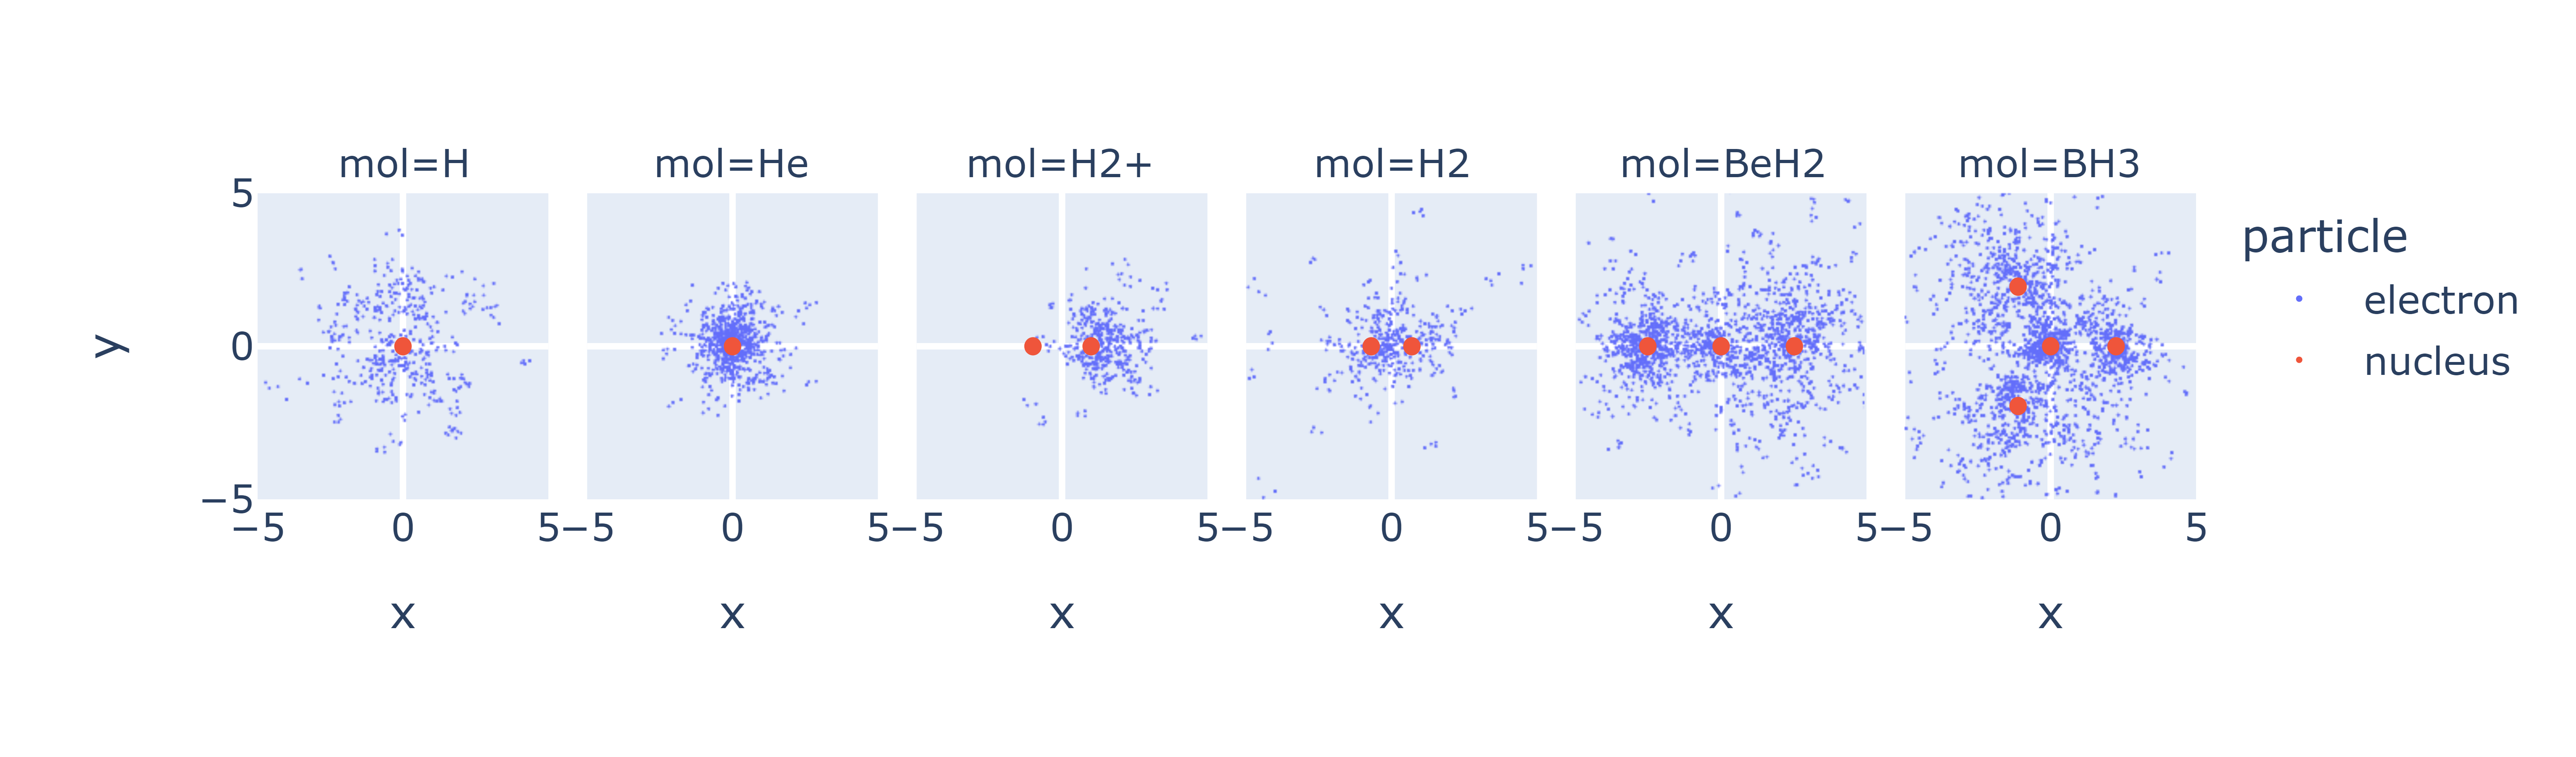

_Figure 3: Electron density plots of learnt wavefunctions from main experiment._

## Discussion

While the ground state energies that we obtained were on the same order of magnitude as the ground truth (15-40% error), they are far from accurate. Notably, we were only able to reach -0.31 for hydrogen, the simplest atom with one electron, whose true ground state energy is -0.5. This is particularly surprising as the neural network ansatz is able to represent the true hydrogen ground state wavefunction $\psi(\mathbf r) \propto e^{-|\mathbf r|}$ exactly by simply learning the constant function for the GNN and $\zeta = 1$ for the envelope.

We hypothesize that the main reason for the poor accuracy is our gradient descent implementation. As mentioned in the Methods section, we treat the points sampled from the wavefunction as fixed while computing the gradient of the loss, and as a result the computed gradient does not capture the dependency of the energy $\mathbb E_{x \sim p}(E_{\mathrm{loc}}(x))$ on the distribution $p(x) \propto |\psi(x)|^2$ from which the points are sampled. This can be a great source of error as the model cannot learn to shift the distribution to regions with lower potential energy. Varying the parameters to shift the distribution to regions with lower potential energy does not change the fixed batch of samples $\{x_1, \ldots, x_B\}$, but the potential energy term in the loss function depend only on these sampled points and is therefore unchanged.

The electron density plots look qualitatively reasonable at first glance as it is mostly concentrated around the nuclei. However, we should keep in mind that the exponentially decaying envelope of the neural network ansatz always results in electron densities concentrated near the nuclei as long as the weights in the other parts of the network do not explode. So the fact that our electron density plots have show electron density conentrated near the nuclei does not mean much. Instead, as mentioned before, the learnt wavefunctions for BeH<sub>2</sub> and BH<sub>3</sub> have high density at a ring of radius 50 (not shown in the plots), which is particularly concerning. We believe that the aforementioned issue with gradient descent is a likely reason for this behavior.

# Conclusion

We demonstrated the feasibility of using an E(3)-equivariant neural network ansatz to give crude estimates to ground state energies of simple atoms and molecules. However, the results are still far from accurate even after optimizing the wavefunction ansatz for hours.

Future work will focus on 3 directions:
1. Most urgently, the gradient descent implementation needs to be fixed. The gradient descent algorithm in the FermiNet paper ([Pfau et al. 2020](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.033429)) is one approach, although it appears to be unnecessarily convoluted. Instead, we will implement the loss function slightly differently, i.e., as
$$
\mathcal L(\theta) = \frac{\sum_{b=1}^B \frac{p_\theta(x_b)}{p(x_b)}E_{\mathrm{loc}}(x_b)}{\sum_{b=1}^B \frac{p_\theta(x_b)}{p(x_b)}},
$$
where $p(x)$ is equal to $p_\theta(x)$ but fixed with respect to changes in $\theta$ (i.e., its gradient with respect to $\theta$ is detached). Then $\mathcal L(\theta)$ continues to approximate the energy of the wavefunction $\psi_\theta$ even as we vary the parameters $\theta$ but leave the samples $x_b$ fixed. 

2. It would be interesting to test the effect of including E(3)-equivariance in the model. To do this, we can conduct an ablations experiment where the E3FermiNet architecture is modified so that it is no longer E(3)-equivariant. For example, instead of constructing scalar features to feed into the GNN, we can simply pass in the coordinates and mangitudes of the positions of the electrons relative to the nuclei, just like the original FermiNet architecture.

3. It would also be interesting to try out different model architectures. For example, we can take advantage of E(3)-equivariant neural networks by representing the wavefunction in a completely different way. Instead of a neural network taking in the positions of the electrons and nuclei and outputing the scalar values of molecular orbital wavefunctions, we first write each molecular orbital wavefunction as a linear combination of basis functions of the form $R_n(r)Y_{lm}(\theta, \varphi)$ around each atom. We then have the neural network take in nuclei positions and predict the coefficients $c_{nlm}$ that go in front of these basis functions. Coefficients $c_{nlm}$ with the same $l$ transform as irreps of $\mathrm{O}(3)$, so an $\mathrm{O}(3)$-equivariant neural network is the perfect model for predicting these coefficients. We already have some preliminary work exploring the feasibility of such a model, described in the Appendix.

# Appendix: Preliminary results on a model based on spherical harmonic basis functions

An alternative approac
As a proof of concept, we will implement this model on the hydrogen atom. We take the total wavefunction to be the product of a radial part and an angular part, consisting of spherical harmonics which transform eqivariantly. The radial part as before will be invariant.

In [ ]:
# Set up model

radial = e3nn.flax.MultiLayerPerceptron([5, 1], act=jax.nn.gelu, output_activation=jax.nn.sigmoid)
angular = e3nn.flax.MultiLayerPerceptron([5, 1], act=jax.nn.gelu, output_activation=jax.nn.sigmoid)
N_samples = 2000
max_r = 4
regularize_pow = 8
regularize_coeff = 100

def wavefunction_H(w, in_points):
  return mlp_H.apply(w, e3nn.tensor_square(e3nn.IrrepsArray("1o", in_points)).filter(keep="0e")).array.squeeze(-1)

@jit
def energy_H(w, in_points):
  psi = wavefunction_H(w, in_points)
  @vmap
  def laplacian(in_points):
    return jnp.einsum('ii->', jacobian(jacobian(wavefunction_H, argnums=1), argnums=1)(w, in_points))
  laplacian_psi = laplacian(in_points)
  cum_K = -0.5 * jnp.dot(psi, laplacian_psi)
  distances = jnp.linalg.norm(in_points, axis=1)
  cum_V = -jnp.dot(psi, psi / distances)
  return (cum_K + cum_V) / jnp.dot(psi, psi)

@jit
def regularized_energy_H(w, in_points):
  psi = wavefunction_H(w, in_points)
  distances = jnp.linalg.norm(in_points, axis=1)
  return energy_H(w, in_points) + regularize_coeff * jnp.dot(psi, psi * (distances / max_r) ** regularize_pow) / jnp.dot(psi, psi)  # penalize high probability near max_r


In [ ]:
random_key = jax.random.PRNGKey(0)
in_points = jax.random.ball(random_key, 3, shape=(N_samples,)) * max_r
random_key += 1
x = e3nn.IrrepsArray("1o", in_points)
x = e3nn.tensor_square(x).filter(keep="0e")

w = mlp_H.init(random_key, x)
random_key += 1
%timeit print(jit(regularized_energy_H)(w, in_points))

In [ ]:
def energy_H(w, N_points = 10000):
  psi = wavefunction_H(w, N_points)
  @vmap
  def laplacian(in_points):
    return jnp.einsum('ii->', jacobian(jacobian(wavefunction_H, argnums=1), argnums=1)(w, in_points))
  laplacian_psi = laplacian(in_points)
  cum_K = -0.5 * jnp.dot(psi, laplacian_psi)
  distances = jnp.linalg.norm(in_points, axis=1)
  cum_V = -jnp.dot(psi, psi / distances)
  return (cum_K + cum_V) / jnp.dot(psi, psi)